# Setup

In [1]:
%matplotlib inline

import torch
import random
import copy
import requests #for sending updates to my phone via telegram
import numpy as np
import pandas as pd
import seaborn as sns

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

from collections import Counter
from torch.autograd import Variable
from torchvision import datasets, transforms
from operator import itemgetter
from tqdm import tqdm, tnrange, tqdm_notebook

sns.set()

In [2]:
with open(r"D:\TELEGRAM_BOTS\NEURALUPDATES.txt") as file: #Credentials for telegram bot
    BOT_TOKEN, CHANNEL = file.read().split('\n')

# Dataloaders

## Clean MNIST loaders

In [3]:
torch.manual_seed(1);

In [4]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       #transforms.Normalize((0.1307,), (0.3081,)) #normalise pixels using mean and stdev
                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) #normalise to range -1 to 1
                   ])



MNIST_train = datasets.MNIST(r'D:\Data_sets/MNIST', train=True, download=True,
                   transform=transform)

MNIST_test = datasets.MNIST(r'D:\Data_sets/MNIST', train=False, download=True,
                   transform=transform)

In [5]:
train_loader = torch.utils.data.DataLoader(MNIST_train, 
                                           batch_size=64, 
                                           shuffle=True, 
                                           pin_memory=True)

test_loader = torch.utils.data.DataLoader(MNIST_test,
                                          batch_size=1000, 
                                          shuffle=True, 
                                          pin_memory=True)

## Adversarial loader

In [6]:
class AdversarialDataset(torch.utils.data.Dataset):
    """FGSM adversarials of MNIST test set"""

    def __init__(self, root_dir, transform=None):

        self.adversarials = np.load(root_dir+'/adversarials.npy')
        self.labels = np.load(root_dir+'/labels.npy')
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        
        image = self.adversarials[idx]
        label = self.labels[idx]

        if self.transform:
            sample = self.transform(sample)

        return image, label

In [7]:
adversarials = AdversarialDataset('D:/Data_sets/Adversarial/MNIST')

In [8]:
adversarial_loader = torch.utils.data.DataLoader(adversarials, 
                                           batch_size=1000, 
                                           shuffle=True, 
                                           pin_memory=True)

# Hyperparameter space

In [9]:
LAYER_SPACE = {
    'nb_units':{'lb': 128, 'ub':2048, 'mutate': 0.15},
    'dropout_rate': {'lb': 0.0, 'ub': 0.7, 'mutate': 0.2},
    'activation': {'func': ['linear','tanh','relu','sigmoid','elu'], 'mutate':0.2}
}

In [10]:
NET_SPACE = {
    'nb_layers': {'lb': 1, 'ub': 3, 'mutate': 0.15},
    'lr': {'lb': 0.001, 'ub':0.1, 'mutate': 0.15},
    'weight_decay': {'lb': 0.00001, 'ub': 0.0004, 'mutate':0.2},
    'optimizer': {'func': ['sgd', 'adam', 'adadelta','rmsprop'], 'mutate': 0.2}
}

# Randomise network

In [11]:
def random_value(space):
    """Returns random value from space."""
    
    val = None
    
    if 'func' in space: #randomise optimiser or activation function
        val = random.sample(space['func'], 1)[0] 
    
    elif isinstance(space['lb'], int): #randomise number of units or layers
        val = random.randint(space['lb'], space['ub'])
    
    else: #randomise percentages, i.e. dropout rates or weight decay
        val = random.random() * (space['ub'] - space['lb']) + space['lb']
    
    return val

In [12]:
def randomize_network(layer_space, net_space): 
    """Returns a randomised neural network"""
    net = {}
    
    for key in net_space.keys():
        net[key] = random_value(net_space[key])
        
    layers = []
    
    for i in range(net['nb_layers']):
        layer = {}
        for key in layer_space.keys():
            layer[key] = random_value(layer_space[key])
        layers.append(layer)
        net['layers'] = layers
        
    return net

In [13]:
randomize_network(LAYER_SPACE, NET_SPACE)

{'layers': [{'activation': 'elu',
   'dropout_rate': 0.006268951960007185,
   'nb_units': 1618},
  {'activation': 'relu',
   'dropout_rate': 0.040534166792839776,
   'nb_units': 830}],
 'lr': 0.0884203213680065,
 'nb_layers': 2,
 'optimizer': 'adam',
 'weight_decay': 0.00038861065480413925}

# Mutate network

In [14]:
def mutate_net(nnet, layer_space, net_space):
    
    net = copy.deepcopy(nnet)
    
    
    # mutate optimizer
    for k in ['lr', 'weight_decay', 'optimizer']:
        if random.random() < net_space[k]['mutate']:
            net[k] = random_value(net_space[k])
    
    
    # mutate layers
    for layer in net['layers']:
        for k in layer_space.keys():
            if random.random() < layer_space[k]['mutate']:
                layer[k] = random_value(layer_space[k])
                
                
    # mutate number of layers -- 50% add 50% remove
    if random.random() < net_space['nb_layers']['mutate']:
        if net['nb_layers'] <= net_space['nb_layers']['ub']:
            if random.random()< 0.5 and \
            net['nb_layers'] < net_space['nb_layers']['ub']:
                layer = {}
                for key in layer_space.keys():
                    layer[key] = random_value(layer_space[key])
                net['layers'].append(layer)      
            else:
                if net['nb_layers'] > 1:
                    net['layers'].pop()

                
            # value & id update
            net['nb_layers'] = len(net['layers'])         
            
    return net

# NetBuilder

In [15]:
class Flatten(nn.Module):
    """Flattens input to vector size (batchsize, 1)
    (for use in NetFromBuildInfo)."""

    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        return x.view(x.size(0), -1)

In [16]:
class NetFromBuildInfo(nn.Module):
    def __init__(self, build_info):
        super(NetFromBuildInfo, self).__init__()
        
        self.activation_dict = {
            'tanh': nn.Tanh(),
            'relu': nn.ReLU(),
            'sigmoid': nn.Sigmoid(),
            'elu': nn.ELU()
            }

        #NETWORK DEFINITION
        
        previous_units = 28 * 28 #MNIST shape
        
        self.model = nn.Sequential()
        self.model.add_module('flatten', Flatten())
         
        for i, layer_info in enumerate(build_info['layers']):
            i = str(i)
            
            self.model.add_module(
                'fc_' + i,
                nn.Linear(previous_units, layer_info['nb_units'])
                )
            
            previous_units = layer_info['nb_units']
            
            self.model.add_module(
                'dropout_' + i,
                nn.Dropout(p=layer_info['dropout_rate'])
                )
            if layer_info['activation'] == 'linear':
                continue #linear activation is identity function
            self.model.add_module(
                layer_info['activation']+ i,
                self.activation_dict[layer_info['activation']])

        self.model.add_module(
            'logits',
            nn.Linear(previous_units, 10) #10 MNIST classes
            )
        
        
        ##OPTIMIZER

        self.opt_args = {#'params': self.model.parameters(),
                 'weight_decay': build_info['weight_decay'],
                 'lr': build_info['lr']
                 }
        
        self.optimizer_dict = {
            'adam': optim.Adam(self.model.parameters(),**self.opt_args),
            'rmsprop': optim.RMSprop(self.model.parameters(),**self.opt_args),
            'adadelta':optim.Adadelta(self.model.parameters(),**self.opt_args),
            'sgd': optim.SGD(self.model.parameters(), **self.opt_args, momentum=0.9) #momentum to train faster
            }

        self.optimizer = self.optimizer_dict[build_info['optimizer']]
        
        
    def forward(self, x):
        x = self.model(x)
        return F.log_softmax(x, dim=1)

In [17]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Train test helpers

In [18]:
def train(model, train_loader, optimizer, epoch):
    
    model.train(True)
    
    running_loss = 0.0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        
        data, target = Variable(data.cuda()), Variable(target.cuda())
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward() 
        optimizer.step()
        running_loss += loss.item()

    running_loss /= len(train_loader.dataset)    
    
    if epoch % 4 == 0:
        print('Train Epoch: {} \t Loss: {:.6f}'.format(epoch, running_loss ))

In [19]:
def test(model, test_loader, adversarial=False, eps=0.5):
    
    model.train(False)
    
    test_loss = 0
    correct = 0
    
    if adversarial:
        for data, target in test_loader:
            data, target = data.cuda(), target.cuda()
            data= fgsm(model, data, target, eps=eps)
            output = model(data)
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred).cuda()).sum().item()
            test_loss += F.nll_loss(output, target, size_average=False).item()
        
    else:
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.cuda(), target.cuda()
                output = model(data)
                test_loss += F.nll_loss(output, target, size_average=False).item()
                pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    
    
    return (test_loss, correct)

# FGSM attack

In [20]:
grads = {} #closure for use as a hook in fgsm attack - otherwise gradients can't be obtained for images. 
def save_grad(name):
    def hook(grad):
        grads[name] = grad
    return hook

In [21]:
def fgsm(model, x, y, eps=0.03, x_val_min=0, x_val_max=1, batch=True): #https://arxiv.org/pdf/1412.6572.pdf
    
    x_adv = Variable(x.data, requires_grad=True).cuda() #clean image
    x_adv.register_hook(save_grad('x_adv'))

    h_adv = model(x_adv) #clean pred
    
    cost = F.nll_loss(h_adv, y.cuda()) #negative log loss clean image and clean pred

    if x_adv.grad is not None:
        x_adv.grad.data.fill_(0)

    cost.backward()

    #x_adv.grad.sign_() #take sign of gradients 
    x_adv = x_adv + (eps*grads['x_adv'].sign())
    x_adv = torch.clamp(x_adv, x_val_min, x_val_max)
    
    if batch == False:
        with torch.no_grad():
            h = model(x)
            h_adv = model(x_adv)

        return x_adv, h_adv, h
    
    return x_adv

# Evolution optimiser

In [22]:
class TournamentOptimizer:
    """Define a tournament play selection process."""

    def __init__(self, population_sz, layer_space, net_space, init_fn, mutate_fn, builder_fn,
                 train_fn, test_fn, data_loader, test_loader, adversarial_loader):
        
        self.init_fn = init_fn
        self.layer_space = layer_space
        self.net_space = net_space
        self.mutate_fn = mutate_fn
        self.builder_fn = builder_fn
        self.train = train_fn
        self.test = test_fn
        self.dataloader = data_loader
        self.testloader = test_loader
        self.population_sz = population_sz
        self.adversarials = adversarial_loader
        
        torch.manual_seed(1);
        
        self.genomes = [init_fn(self.layer_space, self.net_space) for i in range(population_sz)]   
        self.population = []
        
        self.test_results = {} 
        self.genome_history = {} 

        self.generation = 0

    def step(self, generations=1, save=True, phone=False):
        """Tournament evolution step."""

        for _ in tnrange(generations, desc='Overall progress'): #tqdm progress bar

            self.generation += 1

            self.genome_history[self.generation] = self.genomes
            self.population = [NetFromBuildInfo(i).cuda() for i in self.genomes]
            self.children = []
            

            self.train_nets(save=save)
            self.evaluate_nets()

            mean = np.mean(self.test_results[self.generation]['correct'])
            best = np.max(self.test_results[self.generation]['correct'])

            tqdm.write('Generation {} Population mean:{} max:{}'
                       .format(self.generation, mean, best))
            
            if phone: #update via telegram
                requests.post("https://api.telegram.org/bot{}/"
                  "sendMessage".format(BOT_TOKEN), 
                  data={'chat_id': '{}'.format(CHANNEL),
                    'text':'Generation {} completed \n'
                        'Population mean: {} max: {}'
                        .format(self.generation, mean, best)})

                
                

            n_elite = 2
            sorted_pop = np.argsort(self.test_results[self.generation]['correct'])[::-1]
            elite = sorted_pop[:n_elite]
            
            # elites always included in the next population
            self.elite = []
            print('\nTop performers:')
            for no, i in enumerate(elite):
                self.elite.append((self.test_results[self.generation]['correct'][i], 
                                   self.population[i]))    

                self.children.append(self.genomes[i])

                tqdm.write("{}: score:{}".format(no,
                            self.test_results[self.generation]['correct'][i]))   




            #https://stackoverflow.com/questions/31933784/tournament-selection-in-genetic-algorithm
            p = 0.85 # winner probability 
            tournament_size = 3
            probs = [p*((1-p)**i) for i in range(tournament_size-1)]
            probs.append(1-np.sum(probs))
            #probs = [0.85, 0.1275, 0.0224]

            while len(self.children) < self.population_sz:
                pop = range(len(self.population))
                sel_k = random.sample(pop, k=tournament_size)
                fitness_k = list(np.array(self.test_results[self.generation]['correct'])[sel_k])
                selected = zip(sel_k, fitness_k)
                rank = sorted(selected, key=itemgetter(1), reverse=True)
                pick = np.random.choice(tournament_size, size=1, p=probs)[0]
                best = rank[pick][0]
                genome = self.mutate_fn(self.genomes[best], self.layer_space, self.net_space)
                self.children.append(genome)
                
            self.genomes = self.children
                

        
        
    def train_nets(self, save=True):
        """trains population of nets"""
         
        for i, net in enumerate(tqdm_notebook(self.population)):
            for epoch in range(1, 4):
                torch.manual_seed(1);
                self.train(net, self.dataloader, net.optimizer, epoch)
                
            if save:
                fp = r"D:\Models\NeuroEvolution/{}-{}".format(self.generation, i)
                torch.save(net.state_dict(), fp)
                
                
    def evaluate_nets(self):
        """evaluate the models."""
        
        losses = []
        corrects = []
        clean_corrects = []
        
        self.test_results[self.generation] = {}
        
        for i in range(len(self.population)):
            net = self.population[i]
            loss, correct = self.test(net, self.testloader, adversarial=True, eps=0.5) 
            _, clean_correct = self.test(net, self.testloader)
            
            losses.append(loss)
            corrects.append(correct)
            clean_corrects.append(clean_correct)
        
        self.test_results[self.generation]['losses'] = losses
        self.test_results[self.generation]['correct'] = corrects
        self.test_results[self.generation]['clean_correct'] = clean_corrects

# Run 

In [23]:
testing2 = TournamentOptimizer(30, LAYER_SPACE, NET_SPACE, randomize_network, 
                           mutate_net, NetFromBuildInfo, train, test,
                          train_loader, test_loader, adversarial_loader)

In [24]:
testing2.step(generations=50, save=True, phone=True)

Generation 1 Population mean:1834.9333333333334 max:7123

Top performers:
0: score:7123
1: score:5267
Generation 2 Population mean:2573.766666666667 max:7195

Top performers:
0: score:7195
1: score:7163
Generation 3 Population mean:3474.7 max:7544

Top performers:
0: score:7544
1: score:7411
Generation 4 Population mean:4141.266666666666 max:8080

Top performers:
0: score:8080
1: score:7719
Generation 5 Population mean:5441.4 max:7906

Top performers:
0: score:7906
1: score:7905
Generation 6 Population mean:5602.366666666667 max:8092

Top performers:
0: score:8092
1: score:7928
Generation 7 Population mean:4336.4 max:8010

Top performers:
0: score:8010
1: score:7826
Generation 8 Population mean:5698.933333333333 max:8112

Top performers:
0: score:8112
1: score:7952
Generation 9 Population mean:5152.233333333334 max:8054

Top performers:
0: score:8054
1: score:7920
Generation 10 Population mean:6251.733333333334 max:8280

Top performers:
0: score:8280
1: score:8226
Generation 11 Populat

# Progress plots

## Plot func definitions 

In [25]:
def progressplotter(optimizer, clean=False):
    
    if clean:
        dataset = 'clean_correct'
    else:
        dataset = 'correct'
    
    means = []
    
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(111)
    
    gens = range(len(optimizer.test_results))
    popsize = len(optimizer.test_results[1][dataset])
    
    for i in gens:
        ax.scatter([i for j in range(popsize)], optimizer.test_results[i+1][dataset])
        mean = np.mean(optimizer.test_results[i+1][dataset])
        means.append(mean)
        ax.scatter(i, mean, c=1)
        
        if i == 0:
            continue
        plt.plot([i-1, i], [means[i-1], mean], c='black')
        
    ax.set_xticks(np.arange(0, len(means),1))
    ax.set_xlabel('Generation')
    ax.set_ylabel('Correct classifications')
    
    if clean:
        ax.set_title('Accuracy on clean dataset')
    else:
        ax.set_title('Accuracy on adversarial dataset')
    
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]):
        item.set_fontsize(30)
        
    for item in (ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(15)

In [26]:
def diffplotter(optimizer):
    diff = {}
    for gen in optimizer.test_results:
        diff[gen] = []
        for i in range(len(optimizer.test_results[gen]['clean_correct'])):
            clean = optimizer.test_results[gen]['clean_correct'][i]
            adver = optimizer.test_results[gen]['correct'][i]
            diff[gen].append(clean - adver)
            
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(111)

    gens = len(optimizer.test_results)
    popsize = len(optimizer.test_results[gen]['clean_correct'])

    for i in range(gens):
        ax.scatter([i for j in range(popsize)], diff[i+1])
        
    ax.set_title('Difference between clean and adversarial accuracy')
    ax.set_xlabel('Generation')
    ax.set_ylabel('Clean accuracy - adversarial accuracy')
    
    ax.set_xticks(np.arange(0, gens,1))
    
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]):
        item.set_fontsize(30)
        
    for item in (ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(15)

In [27]:
def bestplotter(optimizer, k=0):

    holder = {
        'clean accuracy' : [],
        'adversarial accuracy' : [],
        'number of layers' : [],
        'activation function' : [],
        'dropout rate' : [],
        'optimizer' : [],
        'number of units in layer' : [],
        'learning rate' : [],
    }

    for gen in optimizer.test_results:

        curr = optimizer.test_results[gen]

        best_index = np.argsort(curr['correct'])[::-1][k]

        holder['clean accuracy'].append(curr['clean_correct'][best_index])
        holder['adversarial accuracy'].append(curr['correct'][best_index])

        genome = optimizer.genome_history[gen][best_index]

        holder['number of layers'].append(genome['nb_layers'])
        holder['dropout rate'].append(genome['layers'][0]['dropout_rate'])
        holder['number of units in layer'].append(genome['layers'][0]['nb_units'])
        holder['optimizer'].append(genome['optimizer'])
        holder['activation function'].append(genome['layers'][0]['activation'])
        holder['learning rate'].append(genome['lr'])
        
    gens = len(holder['clean accuracy'])
    
    fig = plt.figure(figsize=(20,20))
    
    for i in range(8):
        ax = fig.add_subplot(4,2, i+1)
        ax.set_ylabel(list(holder.keys())[i])
        ax.set_xlabel('Generation')
        ax.set_xticks(np.arange(0, gens,5))
        ax.yaxis.label.set_fontsize(15)
        
        
        
        for j in range(gens):
            ax.scatter(j, holder[list(holder.keys())[i]][j], c='black')

In [28]:
def avgplotter(optimizer):

    holder = {
        'clean accuracy' : [],
        'adversarial accuracy' : [],
        'number of layers' : [],
        'activation function' : [],
        'dropout rate' : [],
        'optimizer' : [],
        'number of units in layer' : [],
        'learning rate' : [],
    }

    for gen in optimizer.test_results:

        curr = optimizer.test_results[gen]
        genomes = optimizer.genome_history[gen]
        
        templist1 = []
        templist2 = []
        templist3 = []
        templist4 = []
        templist5 = []
        templist6 = []
        for net in genomes:
            templist1.append(net['nb_layers'])
            templist2.append(net['optimizer'])
            templist3.append(net['lr'])
            templist4.append(net['layers'][0]['dropout_rate'])
            templist5.append(net['layers'][0]['nb_units'])
            templist6.append(net['layers'][0]['activation'])
            
            
        holder['number of layers'].append(np.mean(templist1))
        holder['optimizer'].append(Counter(templist2).most_common()[0][0])
        holder['learning rate'].append(np.mean(templist3))
        holder['dropout rate'].append(np.mean(templist4))
        holder['number of units in layer'].append(np.mean(templist5))
        holder['activation function'].append(Counter(templist6).most_common()[0][0])
        

        holder['clean accuracy'].append(np.mean(curr['clean_correct']))
        holder['adversarial accuracy'].append(np.mean(curr['correct']))
            

    gens = len(holder['clean accuracy'])
    
    fig = plt.figure(figsize=(20,20))
    
    for i in range(8):
        ax = fig.add_subplot(4,2, i+1)
        ax.set_ylabel(list(holder.keys())[i])
        ax.set_xlabel('Generation')
        ax.set_xticks(np.arange(0, gens,5))
        ax.yaxis.label.set_fontsize(15)
        
        for j in range(gens):
            ax.scatter(j, holder[list(holder.keys())[i]][j], c='black')

## Plots 

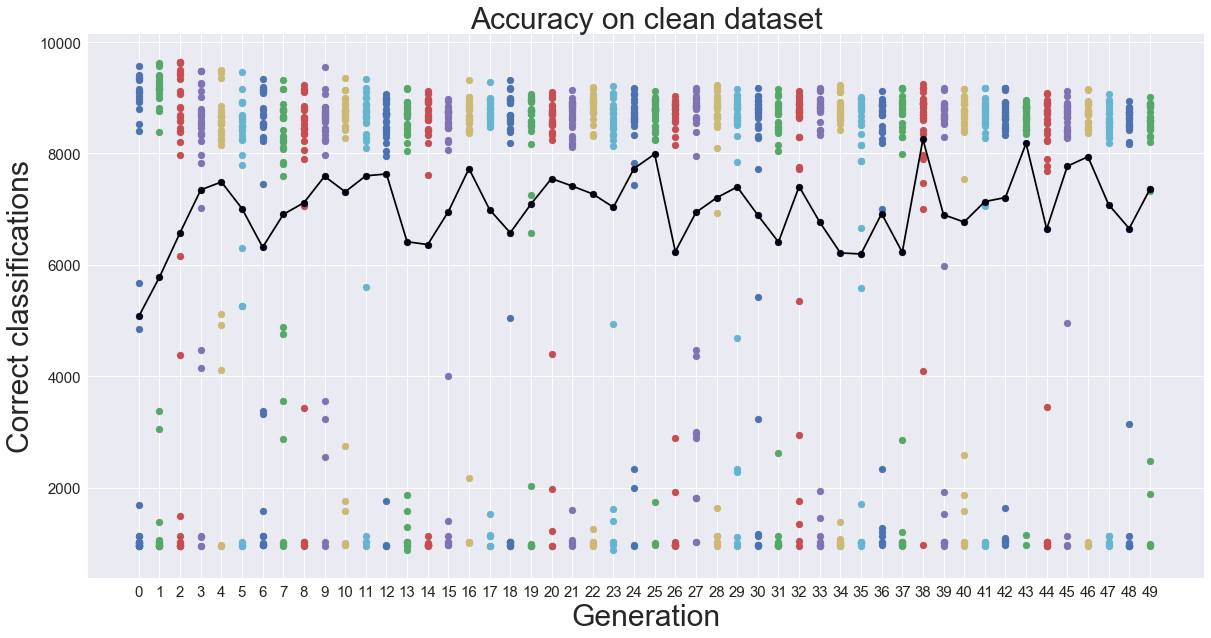

In [29]:
progressplotter(testing2, clean=True)

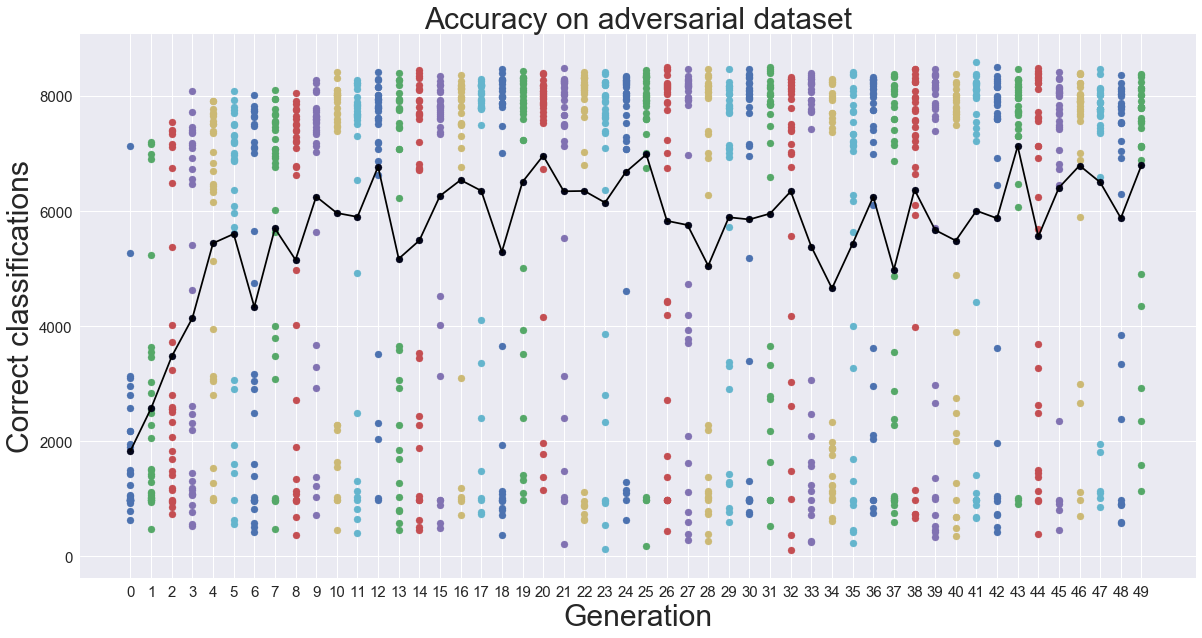

In [30]:
progressplotter(testing2)

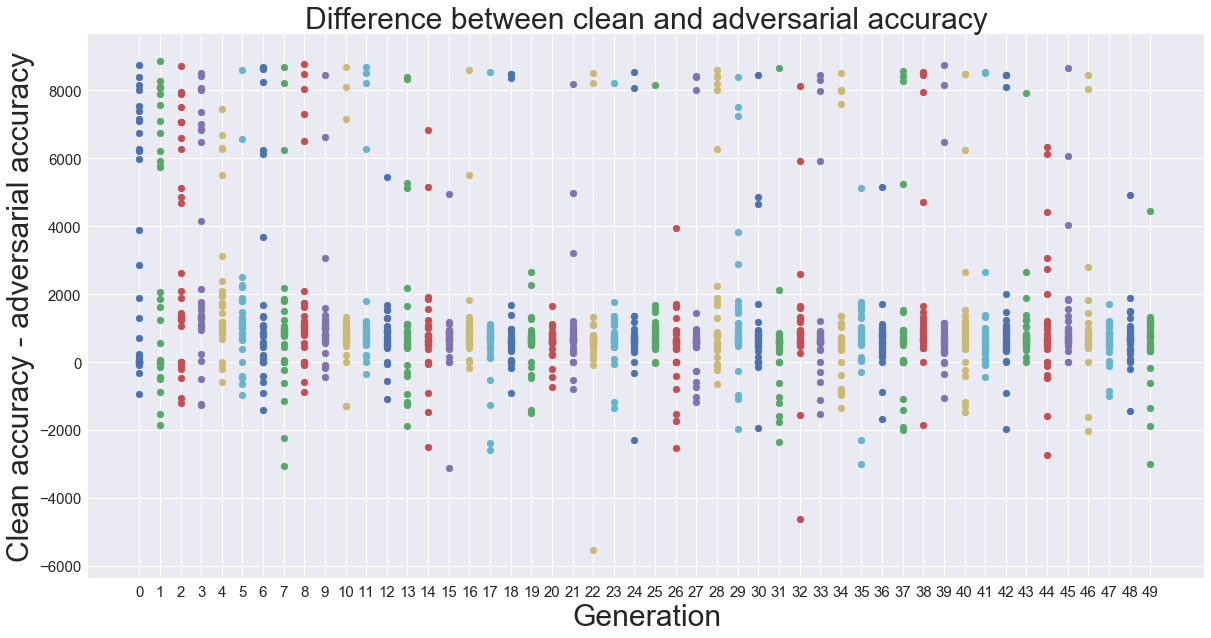

In [31]:
diffplotter(testing2)

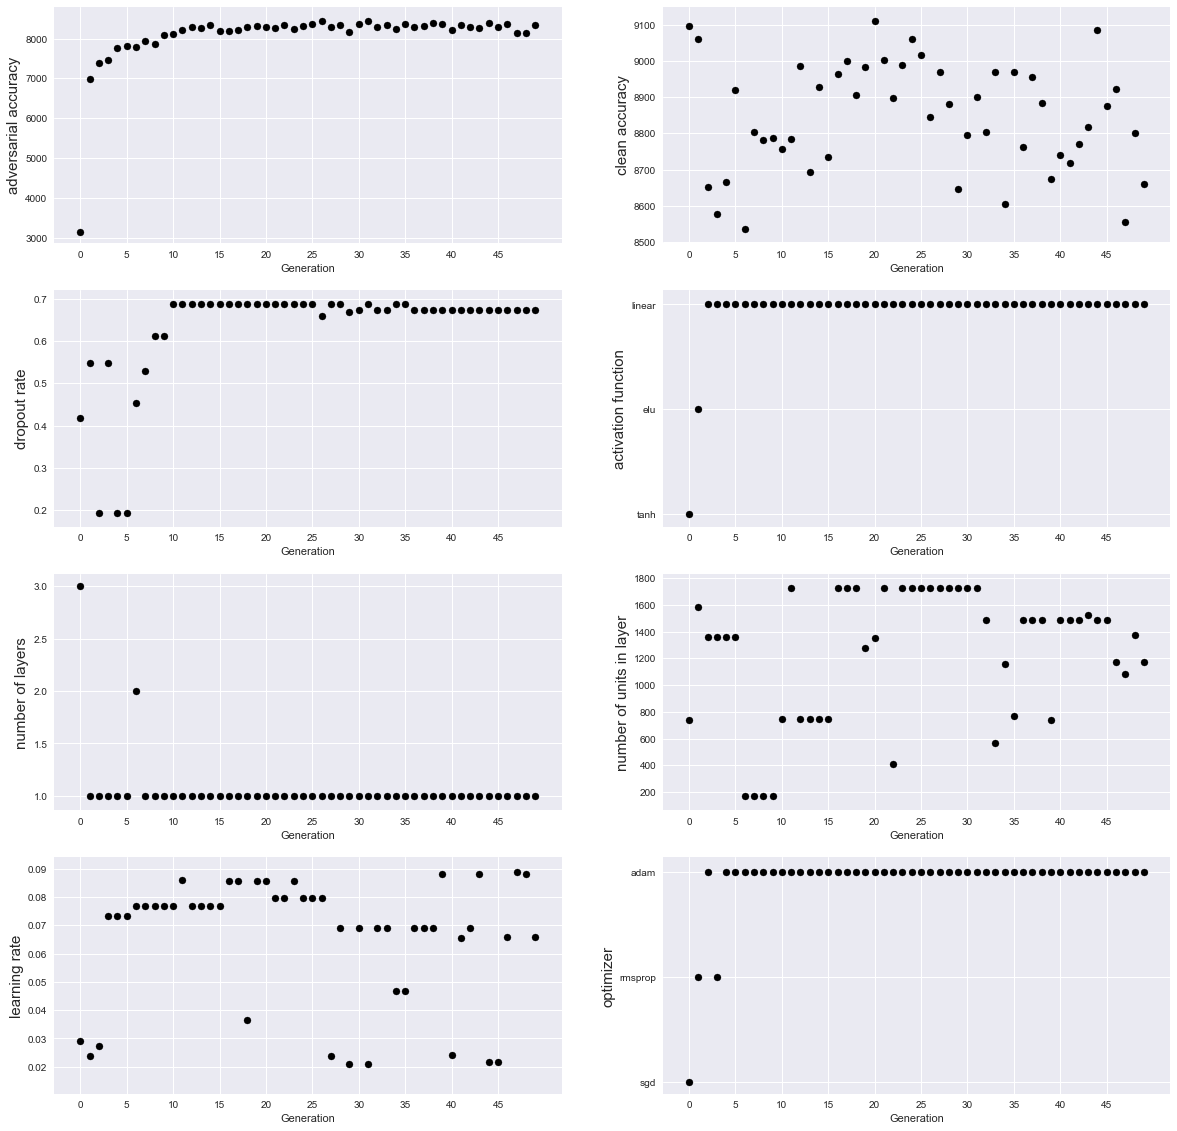

In [32]:
bestplotter(testing2, k=2)

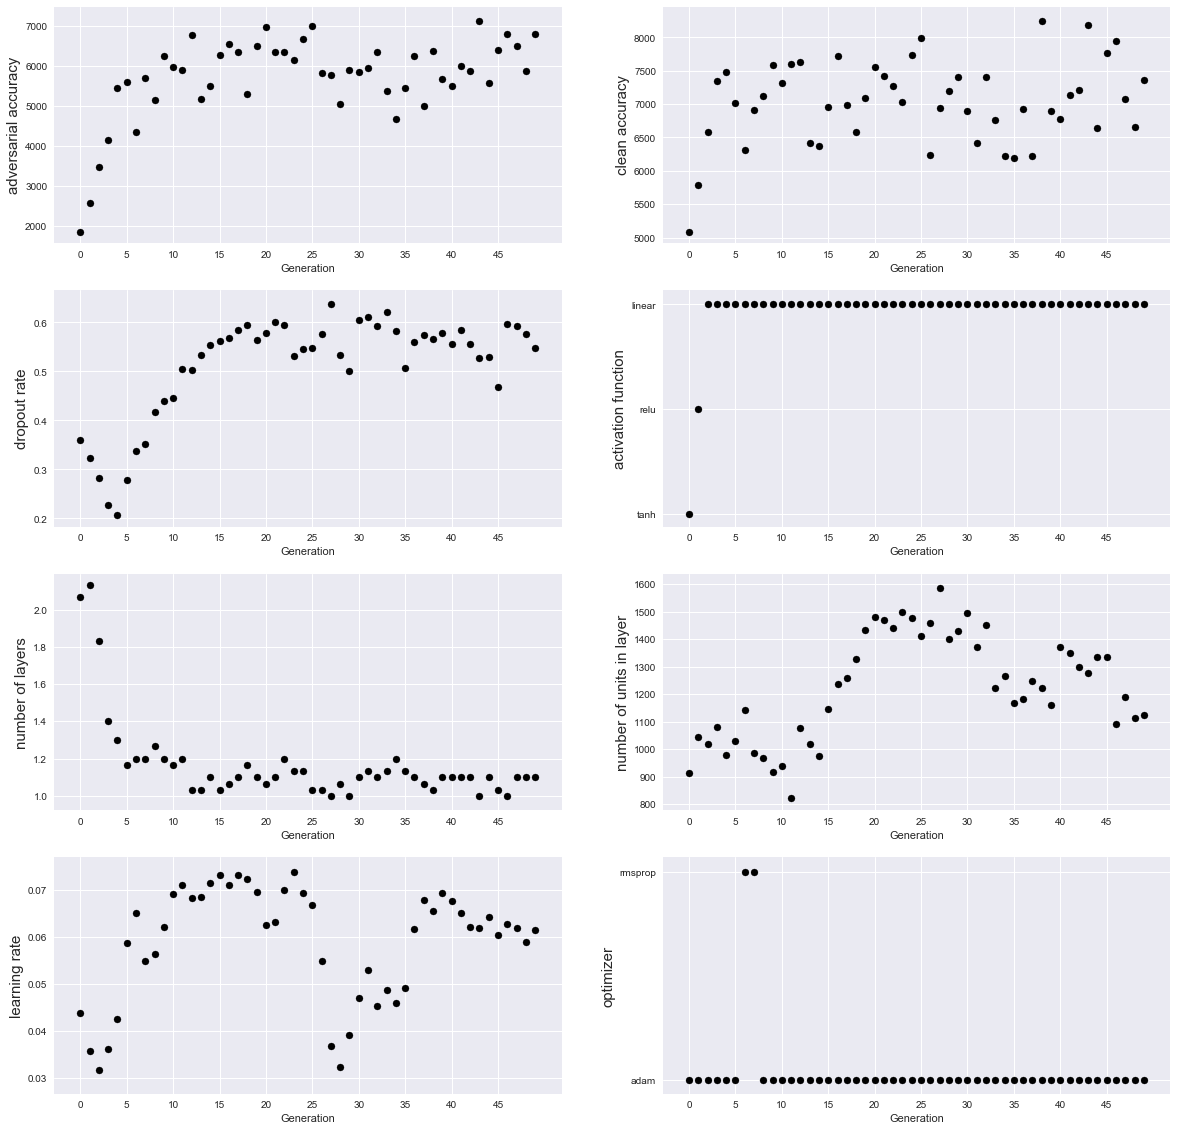

In [33]:
avgplotter(testing2)

# Tests

In [34]:
def rebuild_from_save(optimizer, generation, position):
    
    genome = optimizer.genome_history[generation][position]
    
    net = NetFromBuildInfo(genome)
    
    net.load_state_dict(torch.load(r"D:\Models\NeuroEvolution\{}-{}".format(generation, position)))
    
    return net.cuda()

In [44]:
def sanity_check(optimizer, test_loader):
    
    for generation in optimizer.test_results:
        print('generation {}: \n'.format(generation))
        for i, result in enumerate(optimizer.test_results[generation]['correct']):
            
            mod = rebuild_from_save(optimizer, generation, i)
            _, rebuild_result = test(mod, test_loader, adversarial=True, eps=0.5)
            
            if result == rebuild_result:
                print("result = {}, rebuild result = {}. (equal)".format(result, rebuild_result))
            else:
                print("result = {}, rebuild result = {}. (different!!)".format(result, rebuild_result))

In [45]:
#sanity_check(testing2, test_loader)

generation 1: 

result = 5267, rebuild result = 5396. (different!!)
result = 980, rebuild result = 980. (equal)
result = 960, rebuild result = 960. (equal)
result = 979, rebuild result = 5684. (different!!)
result = 2177, rebuild result = 7285. (different!!)
result = 2582, rebuild result = 4836. (different!!)
result = 7123, rebuild result = 7878. (different!!)
result = 780, rebuild result = 780. (equal)
result = 3105, rebuild result = 7780. (different!!)
result = 1893, rebuild result = 1907. (different!!)
result = 974, rebuild result = 974. (equal)
result = 2171, rebuild result = 7515. (different!!)
result = 3134, rebuild result = 8036. (different!!)
result = 631, rebuild result = 7026. (different!!)
result = 979, rebuild result = 979. (equal)
result = 990, rebuild result = 1009. (different!!)
result = 958, rebuild result = 958. (equal)
result = 2954, rebuild result = 4076. (different!!)
result = 1958, rebuild result = 7285. (different!!)
result = 982, rebuild result = 982. (equal)
res

KeyboardInterrupt: 

# Best model plots 

In [61]:
def get_best_model(optimizer):
    current_best = 0
    for i, gen in enumerate(optimizer.test_results):
        for j, score in enumerate(optimizer.test_results[gen]['correct']):
            if score > current_best:
                best_gen = i
                best_pos = j
                current_best = score
    clean_score = optimizer.test_results[best_gen]['clean_correct'][best_pos]
                
    return [best_gen, clean_score, score, rebuild_from_save(optimizer, best_gen, best_pos)]

In [62]:
best_gen, best_clean_score, best_adv_score, best_model = get_best_model(testing2)

In [89]:
batch = next(iter(test_loader))

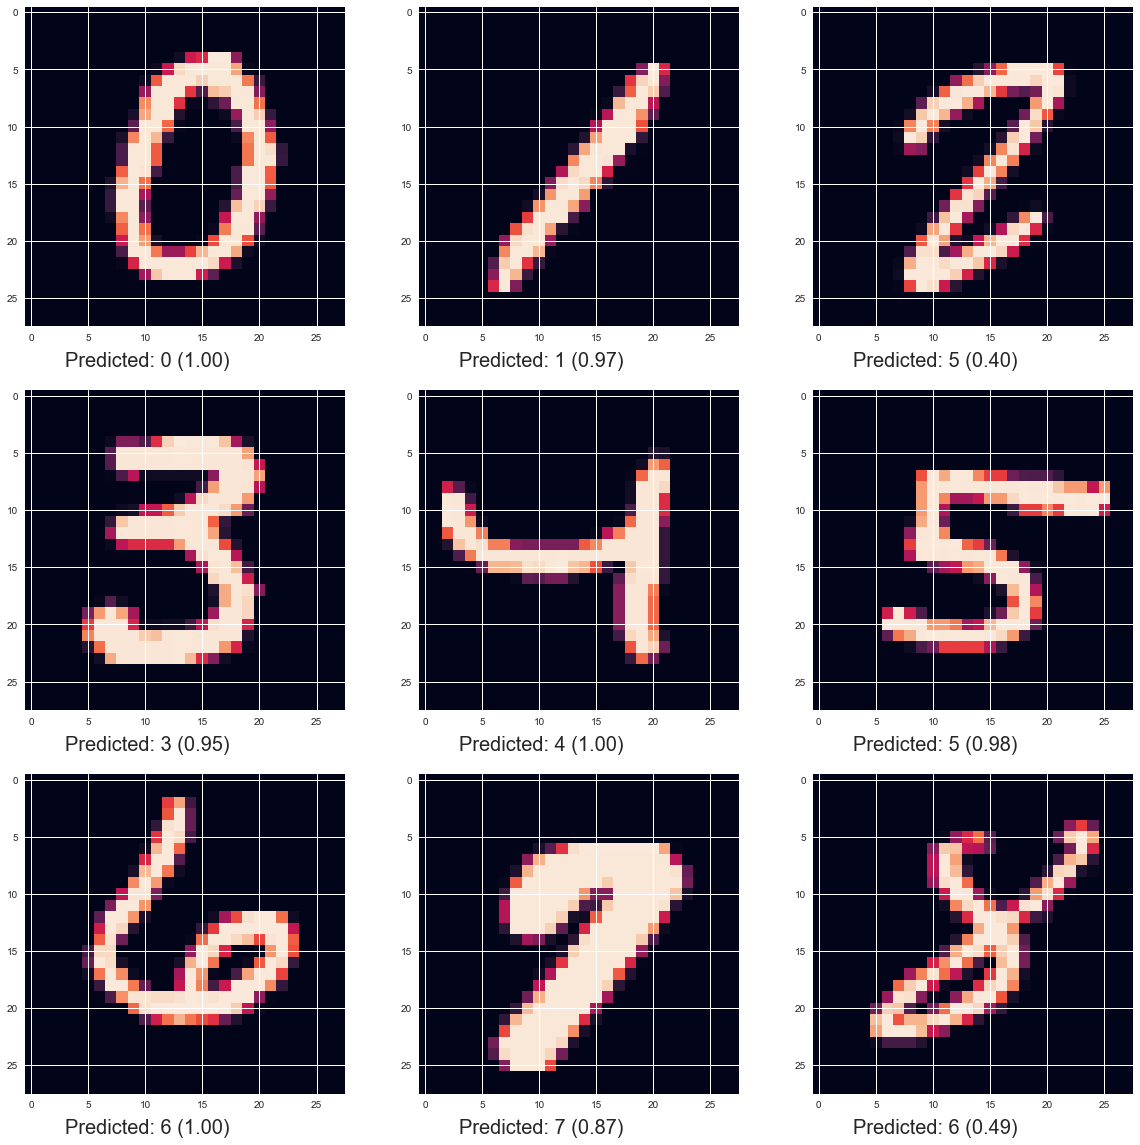

In [110]:
fig = plt.figure(figsize=(20,20))

counter=0
for i in range(len(batch[1])):
    if batch[1][i].item() == counter:
        #do stuff
        counter+=1
        if counter == 10: break
        ax = fig.add_subplot(3,3, counter)
        image = batch[0][i]
        softmax = F.softmax(best_model(image.view(1,1,28,28).cuda()), dim=1)
        prediction = softmax.argmax()
        prediction_pct = softmax.max()
        ax.imshow(image.detach().cpu().numpy().reshape(28,28))
        ax.text(x=3, y=31, s="Predicted: {x} ({y:.2f})"
                 .format(x=prediction, y=prediction_pct), fontsize=20)